In [1]:
import pandas as pd
import numpy as np

import ipywidgets as widgets
from IPython.display import display
from datetime import date, timedelta, datetime

# Import Custom Libraries
import lib.ptm_lib as ptm
import lib.DoR_lib as dor

from lib.crs_lib import *
from lib.utils import *
from lib.fund_lib import *
import wrds

%load_ext autoreload
%autoreload 2


In [2]:
db = wrds.Connection()

Loading library list...
Done


### Function: `main_download_sp500_data`

This function orchestrates the download and merging of **S&P 500 membership data** with **CRSP daily equity data**, creating a unified dataset for analysis.

#### Key Steps:
1. **Directory Setup**: Creates `output_dir` if it doesn't exist.
2. **Download Triggers**:
   - If either `redownloadSP` or `redownloadDSF` is `True`, fresh data is pulled:
     - `download_sp500_membership()` retrieves historical S&P 500 constituents.
     - `download_crsp_daily_data()` fetches CRSP daily stock data for the specified date range.
   - The datasets are merged using `merge_sp500_with_crsp()`.

3. **Cache Reuse**:
   - If both `redownloadSP` and `redownloadDSF` are `False`, loads pre-merged data (if available) to save time.

#### Parameters:
- `db`: Database connection
- `start_date`, `end_date`: Date range for CRSP data
- `output_dir`: Folder to save/load intermediate and merged files
- `redownloadSP`: Whether to force download of S&P 500 membership data
- `redownloadDSF`: Whether to force download of CRSP daily data
- `source`: `'wrds'` or `'raw'` source for CRSP tables

#### Output:
- Returns a merged DataFrame combining CRSP daily data with S&P 500 constituent info.


In [ ]:
sp500_merged_df = main_download_sp500_data(
    start_date='2000-01-01',
    end_date=today,
    output_dir='datasets',
    redownloadSP=False,
    redownloadDSF=False,
    source='wrds' # Use 'raw' CRSP dsf_v2 or 'wrds' enriched data wrds_dsfv2_query
)

In [ ]:
# sp500_merged_df.head(3)

# IC Analysis

In [7]:
# today = datetime.today()
today = pd.to_datetime('2025-08-04')
start_date = (today - timedelta(days=365*26)).strftime('%Y-%m-%d')
end_date = today.strftime('%Y-%m-%d')

### Function: `download_fundamentals`

This function retrieves and optionally caches quarterly fundamental data from the Compustat `fundq` table, enriched with both raw and derived financial metrics.

#### Key Features:
- **Data Source**: Pulls from the WRDS `comp_na_daily_all.fundq` and joins GICS industry data from the `company` table.
- **Time Filter**: Selects records using `pdateq` (publication date) to ensure a bias-free, forward-looking simulation.
- **Filtering**:
  - Only keeps standardized, consolidated, USD-reported firms with valid fiscal data.
  - Includes both active and inactive companies (`costat` in `'A', 'I'`).

#### Includes:
- **Raw Fields**: Market cap, earnings, debt, equity, income, balance sheet and cash flow items.
- **Derived Metrics**:
  - Valuation: `ev`, `pe_ratio`
  - Profitability: `roe`, `roa`, `ebitda`, `nopat`
  - Leverage & Liquidity: `debt_to_assets`, `cash_to_assets`
  - Efficiency & Growth: `eps_qoq_growth`, `sales_yoy_growth`, `capx_q`
  - Free cash flow: `fcf`, `fcf_to_ebit`, `capex_coverage_ratio`, `capex_to_ppe`
  - Custom metrics like `croe` (cash ROE)

#### Output:
- Returns a cleaned and enriched DataFrame.
- Saves the result as a `.parquet` file (compressed with Brotli) for future reuse.
- If the file already exists and `redownload=False`, loads it directly to save time.


In [8]:
fundq = download_fundamentals(db, start_date, end_date, output_dir='datasets', redownload=False)
fundq.head(3)

Saved Fundamentals to datasets/2015-08-07_2025-08-04_fundq.parquet


,gvkey,tic,conm,datadate,pdateq,fyearq,fqtr,rdq,costat,curcdq,...,fcf,fcf_to_ebit,capex_coverage_ratio,capex_to_ppe,roic,croic,fcf_lag,fcf_growth,ebitda_minus_capex_to_ic,ev_to_ebitda
0,001004,AIR,AAR CORP,2015-08-31,2015-09-24,2015,1,2015-09-24,A,USD,...,<NA>,<NA>,<NA>,<NA>,0.004917,<NA>,<NA>,<NA>,<NA>,41.978735
1,001004,AIR,AAR CORP,2015-11-30,2015-12-17,2015,2,2015-12-17,A,USD,...,32.2,2.0125,2.064103,0.054584,0.005721,0.032281,<NA>,<NA>,0.011328,38.025301
2,001004,AIR,AAR CORP,2016-02-29,2016-03-22,2015,3,2016-03-22,A,USD,...,-41.6,-2.567901,-0.954128,0.143705,0.005121,-0.040852,32.2,-1.291925,-0.014927,33.091018


### Function: `download_crsp_daily_data`

This function downloads and optionally caches daily equity price and volume data from CRSP, with support for both WRDS-derived and raw CRSP tables.

#### Parameters:
- `db`: Database connection object.
- `start_date`, `end_date`: Date range for the query.
- `output_dir`: Directory to save the output file.
- `redownload`: If `False`, uses cached `.parquet` file if available.
- `source`: `'wrds'` for WRDS-transformed data or `'raw'` for standard CRSP daily table.

#### Key Features:
- **Table Source**: Chooses between `crsp.wrds_dsfv2_query` and `crsp.dsf_v2` based on `source`.
- **Data Filtering**: Pulls only rows where `securitytype = 'EQTY'` (equities only).
- **Data Fields**:
  - Identifiers: `permno`, `ticker`, `permco`, `primaryexch`, `siccd`, etc.
  - Pricing: `dlyprc`, `dlyopen`, `dlyclose`, `dlyhigh`, `dlylow`
  - Volume & Trading: `dlyvol`, `dlynumtrd`, `shrout`
  - Returns: `dlyret`, `dlyretx`
  - Adjustments: Computes `adj_prc` using cumulative price adjustment factor (`dlycumfacpr`)
  - WRDS-only fields: `naics`, `icbindustry`, `dispaydt`, `disdivamt`

#### Output:
- Returns a cleaned DataFrame with daily stock-level data.
- Saves the result as a compressed `.parquet` file for fast future access.
- If a cached version exists and `redownload=False`, it is loaded instead of querying.


In [9]:
dsf_daily_prices = download_crsp_daily_data(db, start_date, end_date, output_dir='datasets', redownload=False, source='raw')
dsf_daily_prices.head(3)

Saved Daily data to datasets/2015-08-07_2025-08-04_raw_dsfv2_eqty.parquet


,permno,primaryexch,tradingstatusflg,securitytype,ticker,permco,siccd,dlycaldt,dlyprc,dlycap,...,dlyretx,dlyvol,dlyclose,dlylow,dlyhigh,dlyopen,dlynumtrd,shrout,dlycumfacpr,adj_prc
0,10001,A,A,EQTY,EGAS,7953,4925,2015-08-07,9.61,100837.73,...,-0.010299,22046.0,9.61,9.35,9.7,9.7,<NA>,10493,1.0,9.61
1,10025,Q,A,EQTY,AEPI,7975,3081,2015-08-07,52.77,269285.31,...,0.036535,36168.0,52.77,50.75,54.02,50.75,470,5103,1.0,52.77
2,10026,Q,A,EQTY,JJSF,7976,2052,2015-08-07,118.01,2206668.99,...,0.0,46083.0,118.01,115.835,118.31,117.79,704,18699,1.0,118.01


### Function: `download_and_save_gvkey_permno_mapping`

This function retrieves and caches the mapping between **Compustat GVKEYs** and **CRSP PERMNOs** using the CRSP `ccmxpf_linktable`.

#### Key Features:
- **Source Table**: `crsp.ccmxpf_linktable`, which links company identifiers across CRSP and Compustat.
- **Filtering**:
  - Includes only standard link types (`'LU'`, `'LC'`) with `usedflag = 1`
  - Drops entries with null `gvkey` or `lpermno`

#### Fields Returned:
- `gvkey`: Compustat company identifier  
- `permno`: CRSP security identifier  
- `linkdt`: Start date of the link  
- `linkenddt`: End date of the link

#### Output:
- Returns a DataFrame with the cleaned mapping.
- Converts date columns to datetime and uses nullable integer for `permno`.
- Saves the result to a compressed `.parquet` file (`linktable.parquet`) for reuse.
- If `redownload=False` and the file already exists, loads the cached version instead of querying.


In [10]:
gvkey_permno_map = download_and_save_gvkey_permno_mapping(db, output_dir='datasets', redownload=False)
gvkey_permno_map.head(3)

Loaded mapping from datasets/linktable.parquet


,gvkey,permno,linkdt,linkenddt
0,005393,40441,1972-12-14,1979-08-31
1,031700,81581,1995-04-07,2000-12-29
2,017052,55336,1982-01-29,2002-03-28


In [11]:
profit_metrics = ['roe', 'roic', 'roa','ebitda', 'ebitda_minus_capex_to_ic']
valuat_metrics = ['pe_ratio', 'ev_to_ebitda', 'epspxq', 'epsx12', 'ev']
cshflw_metrics = ['fcf', 'fcf_to_ebit', 'capex_coverage_ratio', 'croic', 'croe' ]
growth_metrics = ['fcf_growth', 'eps_qoq_growth', 'eps_yoy_growth', 'sales_qoq_growth', 'sales_yoy_growth']
capitl_metrics = ['cshopq', 'tot_debt', 'tot_capt', 'debt_to_assets', 'capex_to_ppe', 'cash_to_assets', 'wc_assets_to_assets']

all_metrics = profit_metrics + valuat_metrics + cshflw_metrics + growth_metrics + capitl_metrics

### Function: `merge_fundq_and_daily_prices`

This function merges quarterly **fundamental data** (`fundq_df`) with **daily CRSP price data** (`daily_df`) at the `permno` level, using a GVKEY–PERMNO mapping table.

#### Key Features:
- **GVKEY–PERMNO Linking**: Joins Compustat fundamentals to CRSP prices using `ccmxpf_linktable`, respecting active date ranges (`linkdt`, `linkenddt`).
- **Duplicate Filtering**: Removes restatements by keeping the first observation per (`gvkey`, `datadate`).
- **Parallel Merging**:
  - For each `permno`, merges `fundq` rows with matching daily price data using `pandas.merge_ordered` (via `merge_single_permno`).
  - Parallelized with `ThreadPoolExecutor` for speed (`n_jobs` controls concurrency).

#### Options:
- `fundq_cols`: Subset of fundamental columns to include
- `daily_cols`: Subset of daily columns to include
- `max_days_back`: Maximum number of days to look back from `rdq` to match a daily price
- `n_jobs`: Number of threads for parallel processing

#### Output:
- Returns a merged DataFrame containing aligned fundamentals and daily prices per stock (`permno`).
- Supports running inside JupyterLab with no multiprocessing issues.


In [12]:
merged = merge_fundq_and_daily_prices(
    fundq_df=fundq,
    daily_df=dsf_daily_prices,
    gvkey_permno_map=gvkey_permno_map,
    fundq_cols=['gvkey', 'datadate', 'rdq', 'gsector'] + all_metrics,
    daily_cols=['permno', 'dlycaldt', 'adj_prc', 'dlycap'],
    max_days_back=90,
    n_jobs=4 
)

In [137]:
# Create quarterly_df from your merged daily DataFrame
quarterly_df = merged[merged['dlycaldt'] == merged['rdq']].copy()

In [138]:
display(quarterly_df.head(2))
print(f'Lenght of Quarterly data: {len(quarterly_df)}')

,gvkey,datadate,rdq,gsector,roe,roic,roa,ebitda,ebitda_minus_capex_to_ic,pe_ratio,...,tot_debt,tot_capt,debt_to_assets,capex_to_ppe,cash_to_assets,wc_assets_to_assets,permno,dlycaldt,adj_prc,dlycap
0,003504,2015-07-31,2015-09-03,35,0.016726,-0.000358,0.010164,98.861,<NA>,192.391304,...,1307.857,3995.429,0.295716,<NA>,0.003845,0.155138,65541.0,2015-09-03,40.3275,7838052.9
63,003504,2015-10-31,2015-12-03,35,0.01375,-0.000411,0.008223,86.784,0.007533,203.146667,...,1349.957,4017.466,0.30264,0.060294,0.003682,0.157514,65541.0,2015-12-03,35.5125,6905618.7


Lenght of Quarterly data: 128705


### Function: `run_rolling_ic_pipeline`

This function computes monthly **Spearman Information Coefficients (ICs)** between predictive signals and future returns across multiple horizons, applying filtering and preprocessing steps.

#### Key Steps:
1. **Add Forward Returns**: Calculates future returns (`fr1`, `fr2`, etc.) for each stock using `adj_prc`.

2. **Forward Fill Metrics**: Fills missing signal values forward by `permno` and `rdq`.

3. **Filter to Midcaps**: Limits the monthly universe to stocks within the interquartile range of market cap (optional).

4. **Monthly Snapshots**: Iterates over months to extract relevant data and compute ICs.

5. **Compute ICs**: 
   - Ranks both signals and forward returns.
   - Computes Spearman correlations between each signal and each horizon's forward return.
   - Applies this for each monthly snapshot.

6. **Output**: Returns a dictionary of DataFrames:
   - Keys: `IC_fr{h}` for each horizon.
   - Values: Time-indexed DataFrames where rows = months, columns = signals.

#### Notes:
- Skips months with insufficient data.
- Filters out thin universes with fewer than 100 stocks.
- Fast, vectorized IC computation is used via rank correlation.


In [139]:
# Computing rolling statics for a group of metrics and horizons
results_roll_ic = run_rolling_ic_pipeline(quarterly_df, metrics=profit_metrics, horizons=[1,2,3,4])

2015-09: Skipping — no data available.
2024-02: Skipping — no data available.
2024-03: Skipping — no data available.
2024-04: Skipping — no data available.
2024-05: Skipping — no data available.
2024-06: Skipping — no data available.
2024-07: Skipping — no data available.
2024-08: Skipping — no data available.
2024-09: Skipping — no data available.
2024-10: Skipping — no data available.
2024-11: Skipping — no data available.
2024-12: Skipping — no data available.


In [140]:
results_roll_ic['IC_fr1'].tail(3)

,roe,roic,roa,ebitda,ebitda_minus_capex_to_ic
2023-11-01,-0.046081,-0.023525,-0.054701,-0.120375,-0.023875
2023-12-01,0.089401,0.219493,0.105103,0.072458,0.126939
2024-01-01,NaN,NaN,NaN,NaN,NaN


#### Plotting rolling IC of metrics for a specific forward return horizon

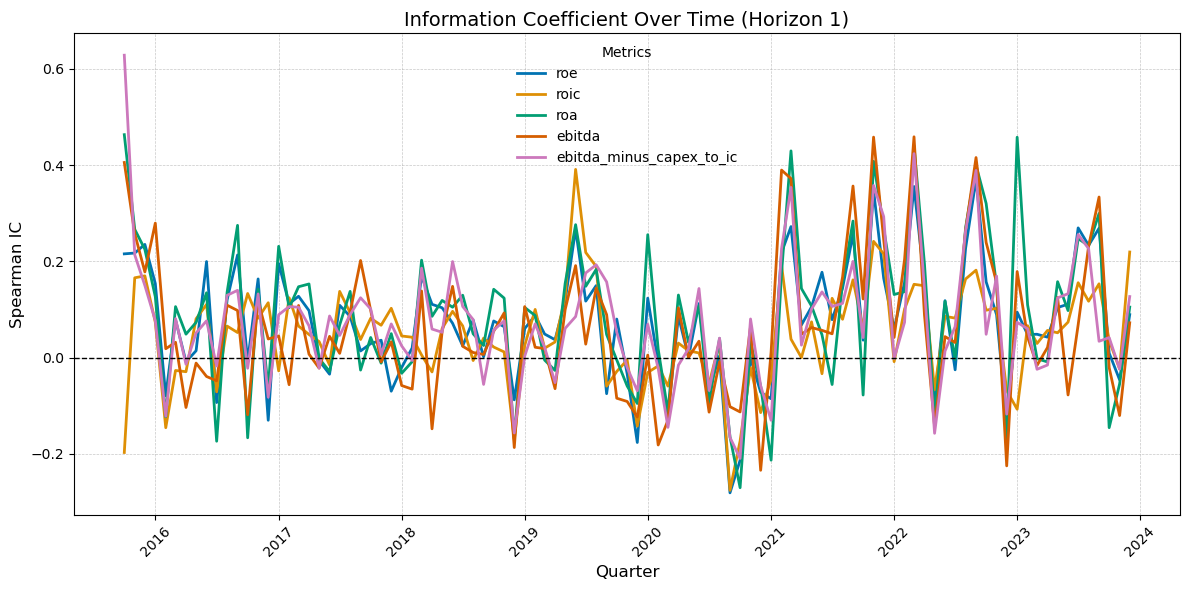

Average ICs across all quarters:
roe                         0.0742
roic                        0.0468
roa                         0.0894
ebitda                      0.0632
ebitda_minus_capex_to_ic    0.0749
dtype: float64


In [141]:
plot_ic_series(ic_dictio=results_roll_ic, horizon=1)

### Function: `summarize_ic_stats`

This function summarizes Information Coefficient (IC) performance metrics and computes rolling statistics for each signal across different forecast horizons.

#### Outputs:
- `summary_stats`: A dictionary of DataFrames (one per horizon) with the following metrics for each signal:
  - `mean_ic`: Average IC
  - `std_ic`: Standard deviation of IC
  - `ic_sharpe`: IC Sharpe ratio (mean / std)
  - `t_stat`: t-statistic of the IC series
  - `pct_pos_windows`: % of rolling windows with positive average IC
  - `sign_flips`: Number of sign changes in rolling mean IC

- `rolling_stats`: A dictionary of rolling time series DataFrames per horizon for:
  - `mean_ic`, `std_ic`, `ic_sharpe`, `t_stat`

#### Notes:
- Rolling metrics are computed using a user-defined window size (default = 8 periods).
- Stability measures (`pct_pos_windows`, `sign_flips`) are computed using non-overlapping rolling windows to assess sign consistency.


In [142]:
summary_stats, rolling_stats = summarize_ic_stats(results_roll_ic, window=8)

In [143]:
summary_stats['IC_fr1']

,metric,mean_ic,std_ic,ic_sharpe,t_stat,pct_pos_windows,sign_flips
0,roe,0.074163,0.121776,0.609014,6.059609,0.833333,0.181818
1,roic,0.046761,0.102264,0.457262,4.549702,0.833333,0.181818
2,roa,0.089408,0.154282,0.579508,5.766033,0.916667,0.181818
3,ebitda,0.063220,0.147857,0.427576,4.254327,0.833333,0.181818
4,ebitda_minus_capex_to_ic,0.074854,0.130243,0.574723,5.718423,0.833333,0.181818


In [144]:
rolling_stats['IC_fr1']['mean_ic'].tail(3)

,roe,roic,roa,ebitda,ebitda_minus_capex_to_ic
2023-10,0.135941,0.084219,0.109830,0.083135,0.096933
2023-11,0.124109,0.077598,0.103279,0.070120,0.096974
2023-12,0.129968,0.097966,0.117528,0.076545,0.114764


#### Heatmap of METRICS for future return (horizon) and parameter (param)

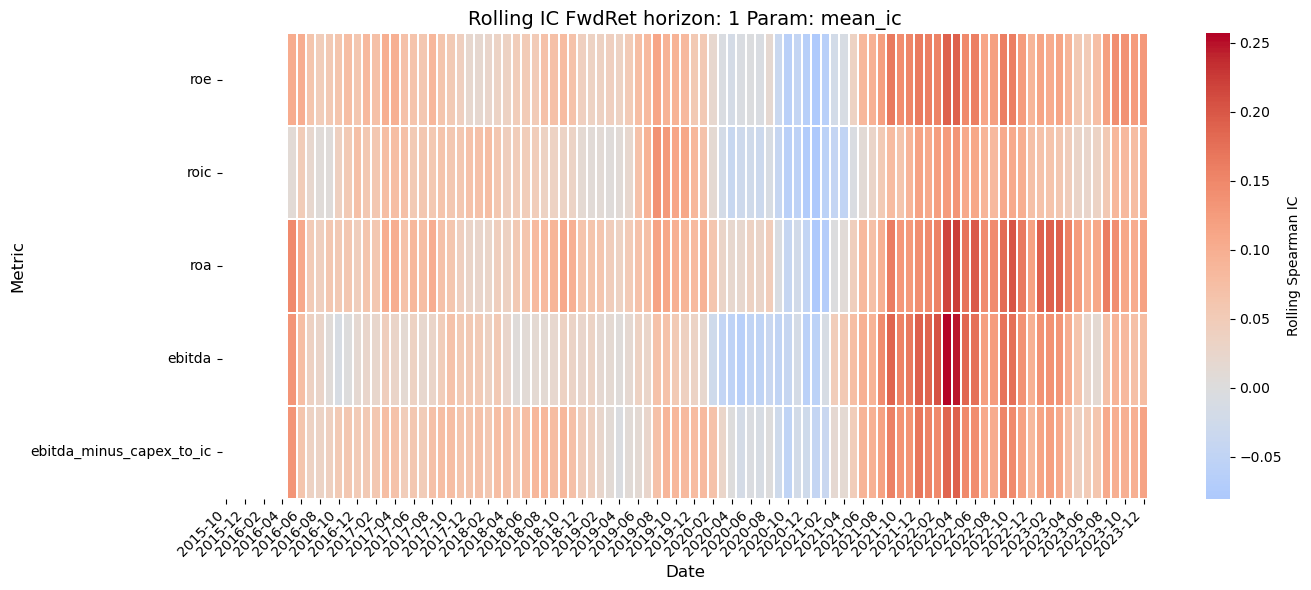

In [145]:
heatmap_ic(rolling_stats, horizon=1, param='mean_ic')

### Function: `compute_composite_final_score`

This function calculates a **final composite score** for each signal by blending two types of stability measures:

1. **Cross-sectional stability** from `summary_stats`:
   - Based on IC Sharpe, t-stat, percent positive ICs, sign flips, and IC standard deviation.
   - Signals are scored using z-scores of these metrics.

2. **Rolling (time-based) stability** from `rolling_stats`:
   - Measures variability of metrics over time using rolling windows.
   - Higher variability implies less stability.

Each component is normalized and weighted (`comp_score_weight`, `roll_stability_score_weight`), and then combined into a single `final_score`.  
The function updates the input `summary_stats` dictionary by adding the computed scores and sorting signals by `final_score` for each horizon.


In [146]:
summary_stats = compute_composite_final_score(summary_stats, rolling_stats)

key: IC_fr1
⚠️ 'sign_flips' has low variance (std=0.00e+00) — excluded from score.
key: IC_fr2
key: IC_fr3
key: IC_fr4


In [147]:
summary_stats['IC_fr1']

,mean_ic,std_ic,ic_sharpe,t_stat,pct_pos_windows,sign_flips,stable_signal,stability_score,rolling_stability_score,final_score
metric,,,,,,,,,,
roa,0.089408,0.154282,0.579508,5.766033,0.916667,0.181818,True,2.137475,1.725634,1.993331
roe,0.074163,0.121776,0.609014,6.059609,0.833333,0.181818,True,2.192351,-0.288897,1.323914
ebitda_minus_capex_to_ic,0.074854,0.130243,0.574723,5.718423,0.833333,0.181818,True,0.795628,1.571670,1.067243
roic,0.046761,0.102264,0.457262,4.549702,0.833333,0.181818,True,-0.931769,-2.556931,-1.500576
ebitda,0.063220,0.147857,0.427576,4.254327,0.833333,0.181818,True,-4.193685,-0.451475,-2.883912


### Function: `plot_composite_score_heatmap`

This function aggregates and visualizes **final composite signal scores** across forecast horizons using a heatmap.

#### Key Features:
- **Input**: `summary_stats` dict with a `'final_score'` column per signal and horizon.
- **Processing**:
  - Constructs a DataFrame of shape `(horizons × signals)` where each cell is a final score.
  - Reorders signals by their average score across horizons.
- **Visualization**:
  - Heatmap (via Seaborn) shows how each signal performs across different horizons.
  - Highlights which signals are most robust and consistent.

#### Parameters:
- `summary_stats`: Dictionary of DataFrames with final scores for each signal.
- `top_n`: Number of top signals to print based on average score.

#### Output:
- Plots a heatmap of composite scores.
- Prints the top `n` signals by mean score.
- Returns the `composite_df` DataFrame for further analysis.


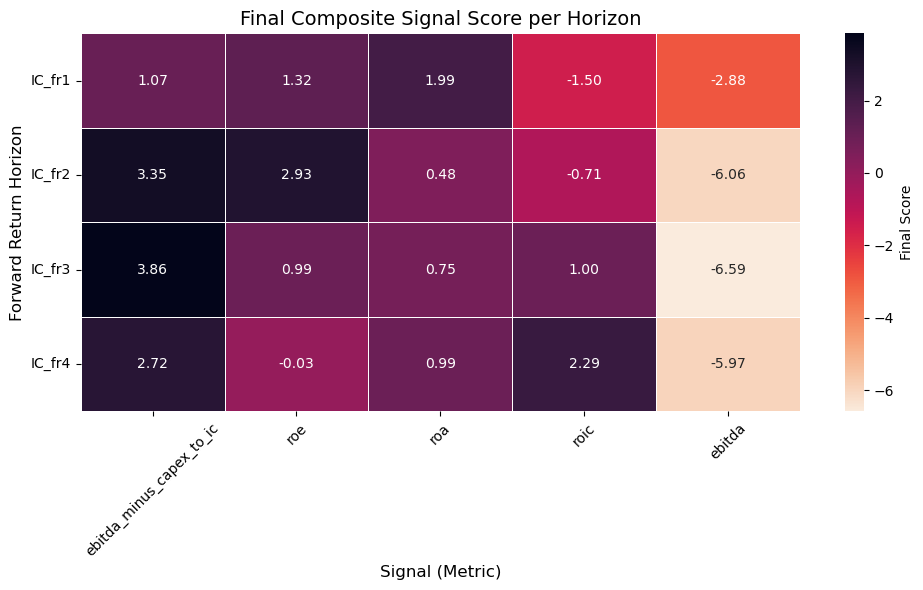


Top 2 signals by mean final score:
metric
ebitda_minus_capex_to_ic    2.7489
roe                         1.3042
dtype: float64


In [152]:
# Aggregate and visualize final composite scores across all horizons.
composite_df = plot_composite_score_heatmap(summary_stats, top_n=2)